<a href="https://colab.research.google.com/github/youngmook/aihub/blob/main/drought_Prediction_SGI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 가뭄 예측 모델

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv('./train_sgi_130_61552.csv')


# EDA: Time Series Analysis

In [3]:
df

,datetime,minTa,minTaHrmt,maxTa,maxTaHrmt,maxPs,maxPsHrmt,minPs,minPsHrmt,ssDur,minTg,ugrwtrl
0,2019-12-02,-1.1,2343,8.8,1316,1022.9,2350,1013.1,328,9.8,-5.1,32.044
1,2019-12-03,-3.0,652,7.7,1242,1025.6,904,1021.6,1406,9.8,-6.5,32.004
2,2019-12-04,-0.2,2400,10.2,1350,1029.0,2315,1024.5,35,9.8,-3.5,32.004
3,2019-12-05,-2.8,2355,7.3,1317,1035.0,2352,1028.9,1,9.8,-7.3,31.981
4,2019-12-06,-5.2,445,6.0,1345,1035.0,1,1028.3,2358,9.7,-8.5,31.949
...,...,...,...,...,...,...,...,...,...,...,...,...
1514,2024-01-27,-1.6,2324,8.8,1302,1026.4,858,1023.7,1410,10.2,-3.9,32.062
1515,2024-01-28,-1.8,627,6.0,1112,1029.7,2031,1024.6,351,10.2,-3.6,32.062
1516,2024-01-29,-2.2,2300,6.4,1107,1030.8,2257,1028.4,1325,10.3,-4.2,32.024
1517,2024-01-30,-3.1,751,7.0,1411,1031.9,919,1026.4,2359,10.3,-4.9,32.024


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1519 entries, 0 to 1518
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datetime   1519 non-null   object 
 1   minTa      1519 non-null   float64
 2   minTaHrmt  1519 non-null   int64  
 3   maxTa      1519 non-null   float64
 4   maxTaHrmt  1519 non-null   int64  
 5   maxPs      1519 non-null   float64
 6   maxPsHrmt  1519 non-null   int64  
 7   minPs      1519 non-null   float64
 8   minPsHrmt  1519 non-null   int64  
 9   ssDur      1519 non-null   float64
 10  minTg      1519 non-null   float64
 11  ugrwtrl    1519 non-null   float64
dtypes: float64(7), int64(4), object(1)
memory usage: 142.5+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
minTa,1519.0,8.923502,9.211105,-16.100,1.200,8.200,17.300,28.700
minTaHrmt,1519.0,950.290981,823.401337,1.000,422.500,606.000,1945.000,2400.000
maxTa,1519.0,17.871626,8.184972,-5.100,11.000,18.600,24.600,37.300
maxTaHrmt,1519.0,1217.616195,367.458272,1.000,1054.000,1250.000,1423.000,2400.000
maxPs,1519.0,1018.718236,7.711324,998.300,1012.700,1019.400,1024.700,1036.700
maxPsHrmt,1519.0,1138.952600,928.467029,1.000,31.500,926.000,2218.000,2400.000
minPs,1519.0,1013.304477,7.975843,960.900,1007.600,1013.400,1019.500,1033.800
minPsHrmt,1519.0,1163.472679,838.090450,1.000,224.000,1433.000,1729.000,2400.000
ssDur,1519.0,12.099671,1.779607,9.600,10.300,12.100,13.800,14.700
minTg,1519.0,7.041870,9.970125,-17.200,-1.500,6.200,16.400,25.700


In [7]:
def decompose_bike_sharing_demand(df, share_type='ugrwtrl', samples=250, period=24):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)

    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid

    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()

    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()

    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()

    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()

    plt.show()

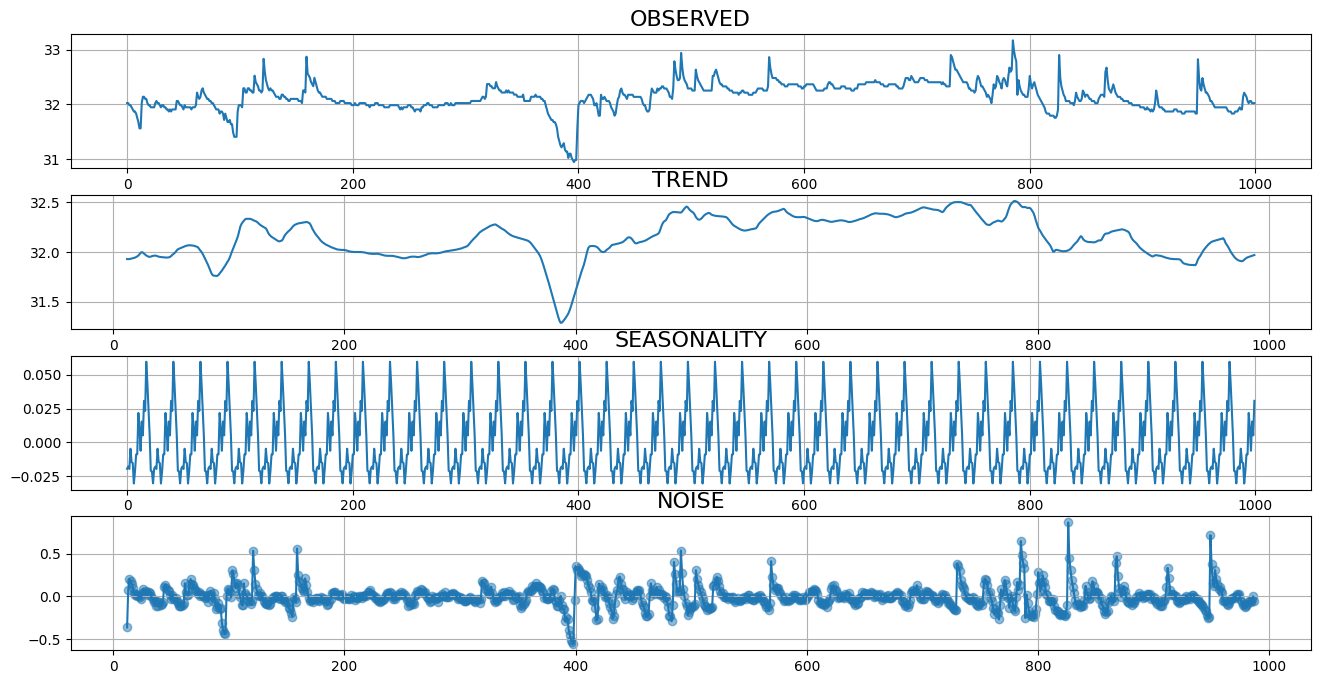

In [8]:
decompose_bike_sharing_demand(df, samples=1000, period=24)

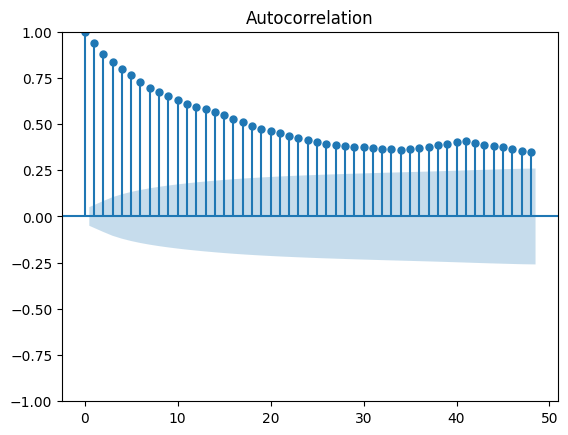

In [9]:
plot_acf(df['ugrwtrl'].values, lags=48)
plt.show()

# Time Series Modelling

# Microsoft's Light Gradient Boosting Machine

In [10]:
df

,datetime,minTa,minTaHrmt,maxTa,maxTaHrmt,maxPs,maxPsHrmt,minPs,minPsHrmt,ssDur,minTg,ugrwtrl
0,2019-12-02,-1.1,2343,8.8,1316,1022.9,2350,1013.1,328,9.8,-5.1,32.044
1,2019-12-03,-3.0,652,7.7,1242,1025.6,904,1021.6,1406,9.8,-6.5,32.004
2,2019-12-04,-0.2,2400,10.2,1350,1029.0,2315,1024.5,35,9.8,-3.5,32.004
3,2019-12-05,-2.8,2355,7.3,1317,1035.0,2352,1028.9,1,9.8,-7.3,31.981
4,2019-12-06,-5.2,445,6.0,1345,1035.0,1,1028.3,2358,9.7,-8.5,31.949
...,...,...,...,...,...,...,...,...,...,...,...,...
1514,2024-01-27,-1.6,2324,8.8,1302,1026.4,858,1023.7,1410,10.2,-3.9,32.062
1515,2024-01-28,-1.8,627,6.0,1112,1029.7,2031,1024.6,351,10.2,-3.6,32.062
1516,2024-01-29,-2.2,2300,6.4,1107,1030.8,2257,1028.4,1325,10.3,-4.2,32.024
1517,2024-01-30,-3.1,751,7.0,1411,1031.9,919,1026.4,2359,10.3,-4.9,32.024


In [12]:
#convert datetime from object to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])
#set datetime as index
df = df.set_index(df.datetime)


In [13]:
df

,datetime,minTa,minTaHrmt,maxTa,maxTaHrmt,maxPs,maxPsHrmt,minPs,minPsHrmt,ssDur,minTg,ugrwtrl
datetime,,,,,,,,,,,,
2019-12-02,2019-12-02,-1.1,2343,8.8,1316,1022.9,2350,1013.1,328,9.8,-5.1,32.044
2019-12-03,2019-12-03,-3.0,652,7.7,1242,1025.6,904,1021.6,1406,9.8,-6.5,32.004
2019-12-04,2019-12-04,-0.2,2400,10.2,1350,1029.0,2315,1024.5,35,9.8,-3.5,32.004
2019-12-05,2019-12-05,-2.8,2355,7.3,1317,1035.0,2352,1028.9,1,9.8,-7.3,31.981
2019-12-06,2019-12-06,-5.2,445,6.0,1345,1035.0,1,1028.3,2358,9.7,-8.5,31.949
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-27,2024-01-27,-1.6,2324,8.8,1302,1026.4,858,1023.7,1410,10.2,-3.9,32.062
2024-01-28,2024-01-28,-1.8,627,6.0,1112,1029.7,2031,1024.6,351,10.2,-3.6,32.062
2024-01-29,2024-01-29,-2.2,2300,6.4,1107,1030.8,2257,1028.4,1325,10.3,-4.2,32.024


In [14]:

#drop datetime column
df.drop('datetime', axis=1, inplace=True)

In [15]:
#create hour, day and month variables from datetime index
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month

#drop casual and registered columns
#df.drop(['casual', 'registered'], axis=1, inplace=True)

In [16]:
df

,minTa,minTaHrmt,maxTa,maxTaHrmt,maxPs,maxPsHrmt,minPs,minPsHrmt,ssDur,minTg,ugrwtrl,hour,day,month
datetime,,,,,,,,,,,,,,
2019-12-02,-1.1,2343,8.8,1316,1022.9,2350,1013.1,328,9.8,-5.1,32.044,0,2,12
2019-12-03,-3.0,652,7.7,1242,1025.6,904,1021.6,1406,9.8,-6.5,32.004,0,3,12
2019-12-04,-0.2,2400,10.2,1350,1029.0,2315,1024.5,35,9.8,-3.5,32.004,0,4,12
2019-12-05,-2.8,2355,7.3,1317,1035.0,2352,1028.9,1,9.8,-7.3,31.981,0,5,12
2019-12-06,-5.2,445,6.0,1345,1035.0,1,1028.3,2358,9.7,-8.5,31.949,0,6,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-27,-1.6,2324,8.8,1302,1026.4,858,1023.7,1410,10.2,-3.9,32.062,0,27,1
2024-01-28,-1.8,627,6.0,1112,1029.7,2031,1024.6,351,10.2,-3.6,32.062,0,28,1
2024-01-29,-2.2,2300,6.4,1107,1030.8,2257,1028.4,1325,10.3,-4.2,32.024,0,29,1


In [19]:
def train_time_series_with_folds(df, horizon=24*7):
    X = df.drop('ugrwtrl', axis=1)
    y = df['ugrwtrl']

    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

    #create, train and do inference of the model
    model = LGBMRegressor(random_state=100)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)

    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('SPI3', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()

    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()

# Train Model without Lags

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2341
[LightGBM] [Info] Number of data points in the train set: 1351, number of used features: 12
[LightGBM] [Info] Start training from score 32.066339


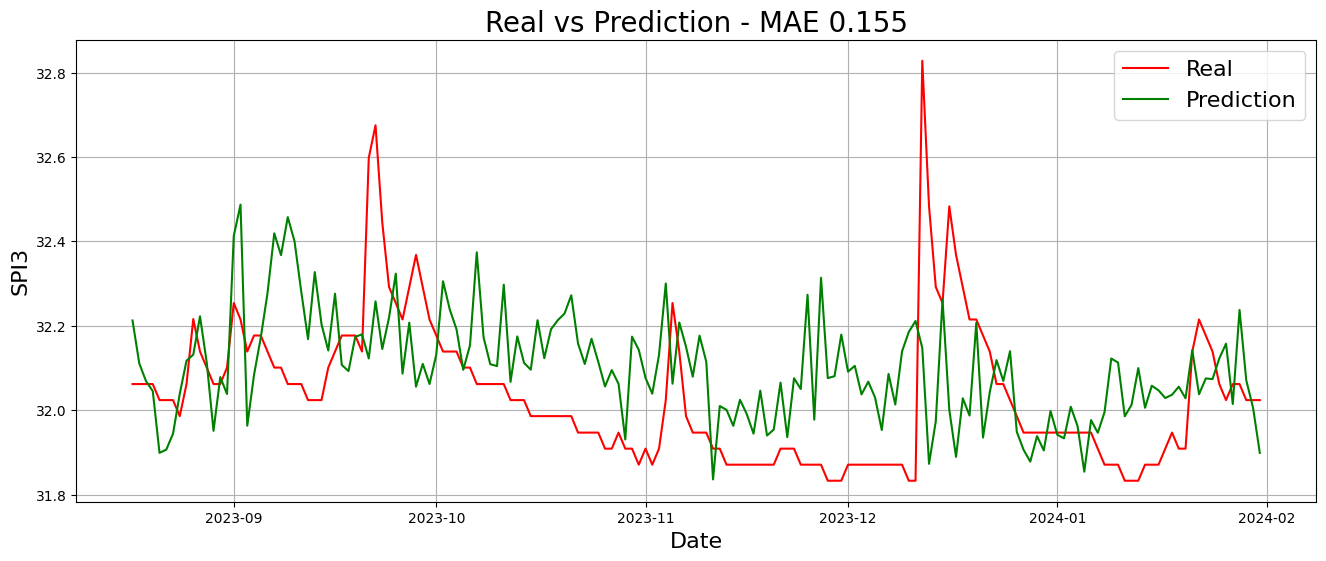

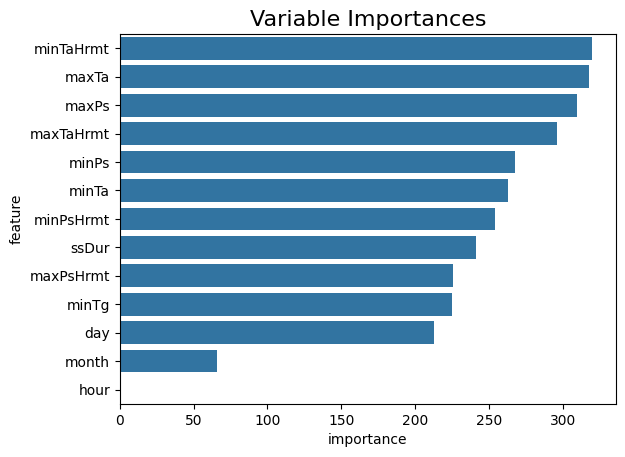

In [20]:
train_time_series_with_folds(df)

# Train Model with Lags

In [31]:
#create 1 week lag variable by shifting the target value for 1 week
df['count_prev_week_same_hour'] = df['ugrwtrl'].shift(7)

#drop NaNs after feature engineering
df.dropna(how='any', axis=0, inplace=True)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2444
[LightGBM] [Info] Number of data points in the train set: 1162, number of used features: 13
[LightGBM] [Info] Start training from score 32.097133


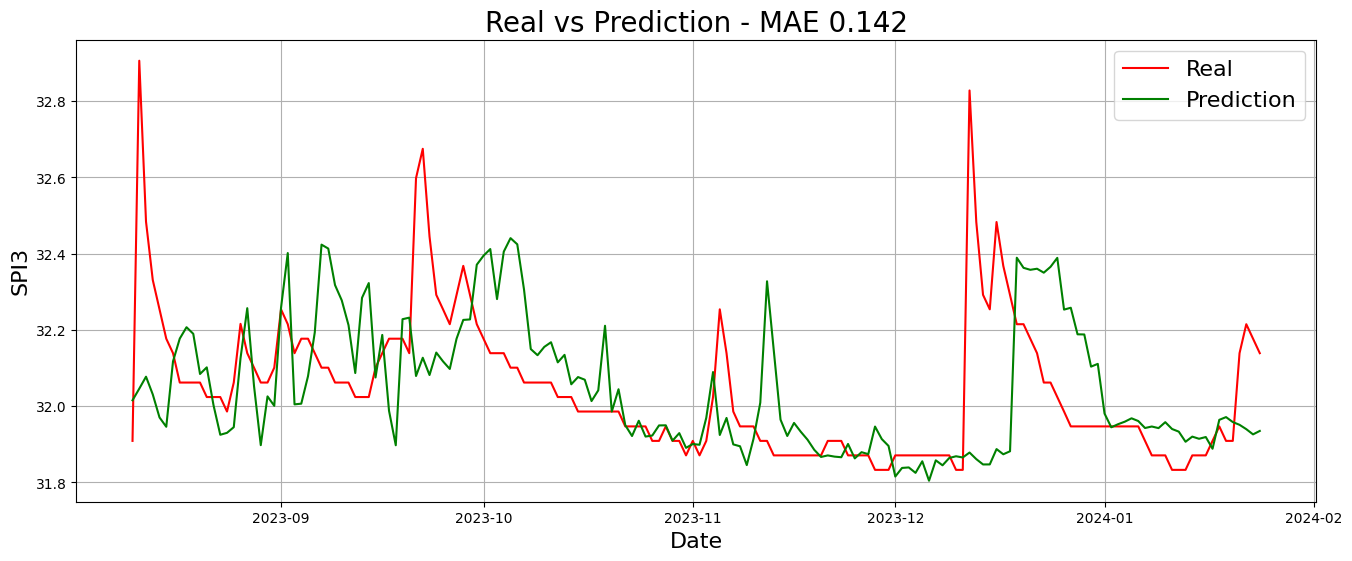

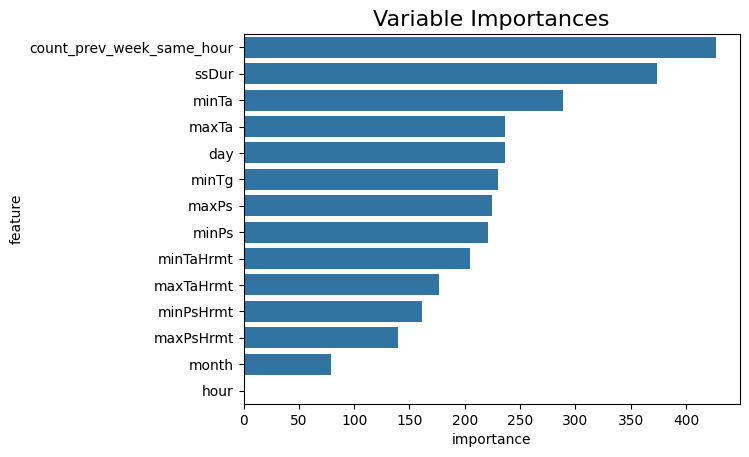

In [32]:
train_time_series_with_folds(df)